In [2]:
# Libraries
import numpy as np
import pandas as pd
import gym
from tqdm import tqdm

from matplotlib import pyplot as plt
from matplotlib.tri import Triangulation
import seaborn as sns

# Pandas configuration
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

sns.set_context("talk")

C:\Users\57350\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\matplotlib_inline\config.py:66: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):


# Q-Learning
The environment is deterministic (it never changes), but the action permormed is not always the same as the input.

In [3]:
# Algorithm Parameters
alpha = 0.5
epsilon = 0.05
gamma = 1


In [4]:
# Environment
env = gym.make("FrozenLake-v1")

states = pd.DataFrame(np.arange(env.observation_space.n), columns = ["state"])
actions = pd.DataFrame(np.arange(env.action_space.n), columns = ["action"])

# Initialize Q(s,a)
Q = states.merge(actions, how='cross')

# Terminal States
terminal_states = [5, 7, 11, 12, 15] 
Q['value'] = np.where(Q['state'].isin(terminal_states), 0, 0.5) # Arbitrary


for _ in tqdm(range(500)):
    
    env.reset()
    state = env.s

    if np.random.rand() < epsilon:
        action = env.action_space.sample()
    else:
        action = Q[Q["state"]==state].sort_values(by="value", ascending = False)["action"].reset_index(drop=True)[0]

    done = False

    while not done:

        #print("State, Action", state,action)
        new_state, reward, done, _ = env.step(action)
        
        if np.random.rand() < epsilon:
            new_action = env.action_space.sample()
        else:
            new_action = Q[Q["state"]==new_state].sort_values(by="value", ascending = False)["action"].reset_index(drop=True)[0]
        
        new_q = float(Q.loc[(Q["state"]==state)&(Q["action"]==action),'value']) + \
            alpha*(reward + float(gamma*Q.loc[(Q["state"]==new_state)&(Q["action"]==new_action),'value']) - \
            float(Q.loc[(Q["state"]==state)&(Q["action"]==action),'value']))

        Q.loc[(Q["state"]==state)&(Q["action"]==action),'value'] = new_q

        state = new_state
        action = new_action

100%|██████████| 500/500 [00:25<00:00, 19.28it/s]


## Policy

In [5]:
policy = Q.copy()
policy["rn"] = Q.sort_values(["state","value"], ascending=[True,False]).groupby(['state']).cumcount() + 1

env_h = 4
env_w = 4

direction_dict = {0:"←", 1:"↓", 2:"→", 3:"↑"}
policy["label"] = policy["action"].apply(lambda x: direction_dict[x])
policy["x"] = policy["state"].apply(lambda x: x//env_w)
policy["y"] = policy["state"].apply(lambda x: x%env_w)

optimal_policy = policy[(policy["rn"]==1) & ~policy["state"].isin(terminal_states)]

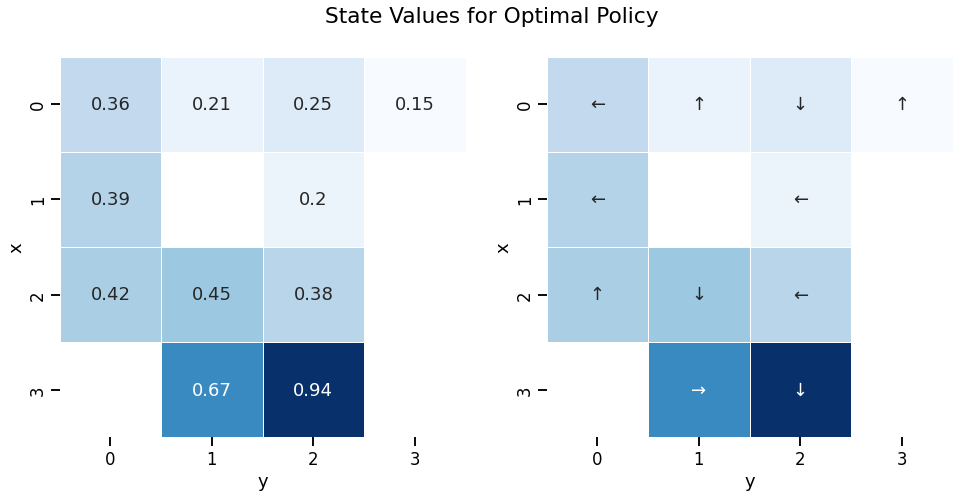

In [8]:
# Reshape Data
returns = optimal_policy.pivot("x", "y", "value")
direction = optimal_policy.pivot("x", "y", "label")

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16,7))
fig.suptitle('State Values for Optimal Policy')

sns.heatmap(returns, annot=True, linewidths=.5, cbar=False, cmap="Blues", ax=axes[0]);
sns.heatmap(returns, annot=np.array(direction), linewidths=.5, cbar=False, cmap="Blues", fmt = '', ax=axes[1]);

In [12]:
policy[~policy["state"].isin(terminal_states)].pivot(index=["x","y"], columns="label", values="value").reset_index()

label,x,y,←,↑,→,↓
0,0,0,0.359894,0.289829,0.283753,0.222564
1,0,1,0.112953,0.205850,0.056962,0.077245
2,0,2,0.097949,0.063063,0.096013,0.254998
3,0,3,0.086027,0.151944,0.019387,0.046318
4,1,0,0.393563,0.128957,0.215406,0.201425
5,1,2,0.197368,0.025918,0.040275,0.039531
6,2,0,0.163107,0.418431,0.330522,0.261770
7,2,1,0.138439,0.247567,0.292038,0.450723
8,2,2,0.383208,0.025816,0.057390,0.125127
9,3,1,0.344656,0.082011,0.669161,0.219725


In [16]:
df

label,x,y,←,↑,→,↓
0,0,0,0.359894,0.289829,0.283753,0.222564
1,0,1,0.112953,0.205850,0.056962,0.077245
2,0,2,0.097949,0.063063,0.096013,0.254998
3,0,3,0.086027,0.151944,0.019387,0.046318
4,1,0,0.393563,0.128957,0.215406,0.201425
5,1,2,0.197368,0.025918,0.040275,0.039531
6,2,0,0.163107,0.418431,0.330522,0.261770
7,2,1,0.138439,0.247567,0.292038,0.450723
8,2,2,0.383208,0.025816,0.057390,0.125127
9,3,1,0.344656,0.082011,0.669161,0.219725


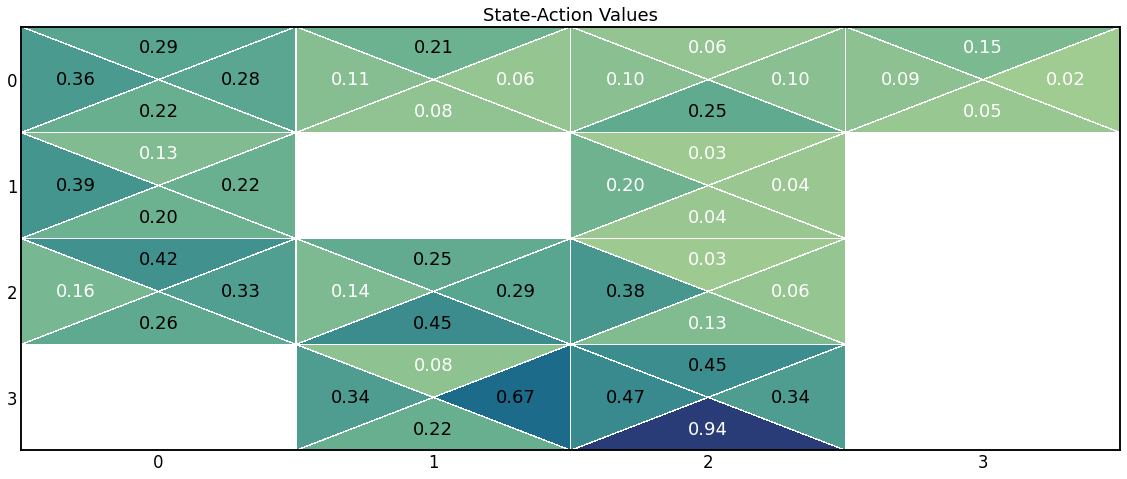

In [14]:
from matplotlib.tri import Triangulation

def triangulation_for_triheatmap(M, N):
    xv, yv = np.meshgrid(np.arange(-0.5, M), np.arange(-0.5, N))  # vertices of the little squares
    xc, yc = np.meshgrid(np.arange(0, M), np.arange(0, N))  # centers of the little squares
    x = np.concatenate([xv.ravel(), xc.ravel()])
    y = np.concatenate([yv.ravel(), yc.ravel()])
    cstart = (M + 1) * (N + 1)  # indices of the centers

    trianglesN = [(i + j * (M + 1), i + 1 + j * (M + 1), cstart + i + j * M)
                  for j in range(N) for i in range(M)]
    trianglesE = [(i + 1 + j * (M + 1), i + 1 + (j + 1) * (M + 1), cstart + i + j * M)
                  for j in range(N) for i in range(M)]
    trianglesS = [(i + 1 + (j + 1) * (M + 1), i + (j + 1) * (M + 1), cstart + i + j * M)
                  for j in range(N) for i in range(M)]
    trianglesW = [(i + (j + 1) * (M + 1), i + j * (M + 1), cstart + i + j * M)
                  for j in range(N) for i in range(M)]
    return [Triangulation(x, y, triangles) for triangles in [trianglesN, trianglesE, trianglesS, trianglesW]]


df = policy[~policy["state"].isin(terminal_states)].pivot(index=["x","y"], columns="label", values="value").reset_index()
df_piv = df.pivot_table(index='x', columns='y')

M = len(df_piv.columns) // 4
N = len(df_piv)
values = [df_piv[dir] for dir in
          ["↑", "→", "↓","←"]]  # these are the 4 column names in df

triangul = triangulation_for_triheatmap(M, N)
cmaps = ['crest'] * 4

norms = [plt.Normalize(0, 1) for _ in range(4)]
fig, ax = plt.subplots(figsize=(16, 7))
imgs = [ax.tripcolor(t, np.ravel(val), cmap=cmap, norm=norm, ec='white')
        for t, val, cmap, norm in zip(triangul, values, cmaps, norms)]


for val, dir in zip(values, [(-1, 0), (0, 1), (1, 0), (0, -1)]):
    for i in range(M):
        for j in range(N):
            v = val[i][j]
            ax.text(i + 0.3 * dir[1], j + 0.3 * dir[0], f'{v:.2f}', color='k' if 0.2 < v < 0.8 else 'w', ha='center', va='center')

ax.tick_params(length=0)
ax.set_xticks(range(M))
ax.set_xticklabels(df_piv["↑"].columns)
ax.set_yticks(range(N))
ax.set_yticklabels(df_piv.index)
ax.invert_yaxis()
ax.margins(x=0, y=0)

ax.set_title("State-Action Values")

plt.tight_layout()
plt.show()

## Debugger

In [68]:
# Define Policy to use
policy = dict(zip(optimal_policy["state"], optimal_policy["action"]))

# Cache
all_states = []
all_actions = []
all_rewards = []

# Play a games with the optimal policy
env = gym.make("FrozenLake-v1")
env.reset()
env.render()

done = False
state = env.s

all_states = [state]

while not done:

    action = policy[state]
    all_actions.append(action)

    state, reward, done, info = env.step(action)
    all_states.append(state)
    all_rewards.append(reward)

    env.render()

print("States:", all_states)
print("Actions:", all_actions)
print("Rewards:", all_rewards)
    

States: [0, 0, 4, 8, 4, 0, 0, 0, 0, 0, 0, 4, 0, 0, 1, 2, 3, 2, 1, 2, 2, 3, 2, 2, 3, 3, 2, 1, 0, 1, 2, 3, 3, 3, 2, 3, 3, 3, 2, 1, 1, 1, 0, 1, 2, 3, 3, 2, 3, 3, 2, 3, 2, 2, 2, 1, 1, 0, 1, 1, 2, 2, 1, 1, 2, 1, 0, 1, 2, 1, 1, 2, 3, 3, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 3, 3, 2, 2, 3, 3, 3, 3, 3, 2, 1, 2, 2, 1]
Actions: [2, 2, 0, 3, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Rewards: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

In [69]:
# Intuition
policy = {0: 1, 1: 0, 2: 1, 3: 0, 4: 1, 6: 1, 8: 2, 9: 1, 10: 1, 13: 2, 14: 2}

# Cache
all_states = []
all_actions = []
all_rewards = []

# Play a games with the optimal policy
env = gym.make("FrozenLake-v1")
env.reset()
env.render()

done = False
state = env.s

all_states = [state]

while not done:

    action = policy[state]
    all_actions.append(action)

    state, reward, done, info = env.step(action)
    all_states.append(state)
    all_rewards.append(reward)

    env.render()

print("States:", all_states)
print("Actions:", all_actions)
print("Rewards:", all_rewards)

States: [0, 4, 8, 9, 13, 13, 9, 8, 12]
Actions: [1, 1, 2, 1, 2, 2, 1, 2]
Rewards: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
